In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 13.1 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.68 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 593 µs


### Database ERD

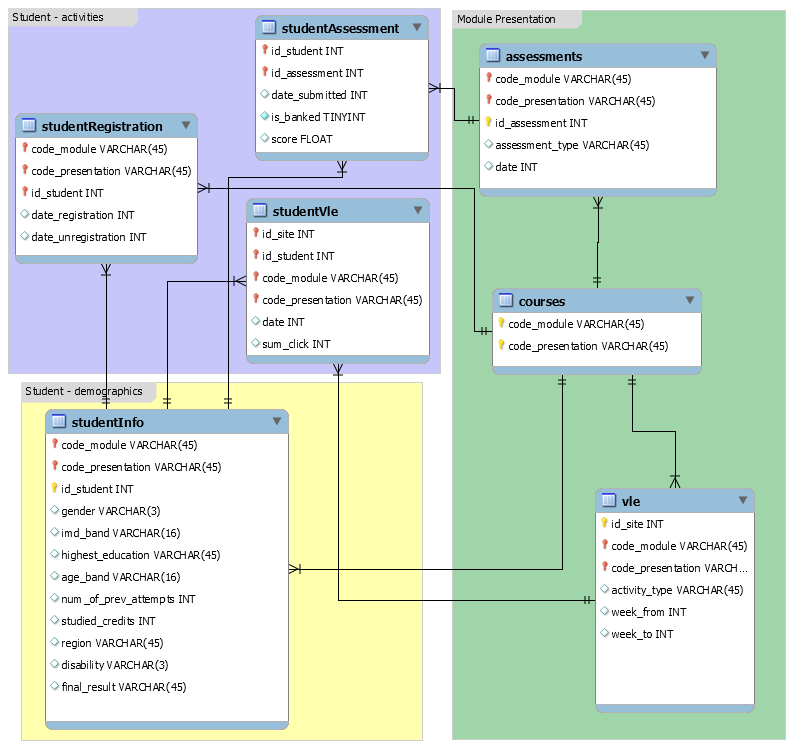

time: 4.38 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.63 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 4.02 ms


## Quarter Term Data

In [8]:
# database_name = 'outcomes.db'
# db_new = db.Database(database_name)

time: 734 µs


In [9]:
df = db.data_prep(60)

time: 9.03 s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26354 entries, 0 to 26353
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                23789 non-null  float64
 1   row_id                26354 non-null  object 
 2   score                 23765 non-null  object 
 3   gender                23789 non-null  object 
 4   region                23789 non-null  object 
 5   highest_education     23789 non-null  object 
 6   imd_band              22824 non-null  object 
 7   age_band              23789 non-null  object 
 8   num_of_prev_attempts  23789 non-null  object 
 9   studied_credits       23789 non-null  float64
 10  disability            23789 non-null  object 
 11  final_result          23789 non-null  object 
 12  date_sub              23789 non-null  float64
 13  course_length         23789 non-null  float64
 14  weighted_ave          23785 non-null  float64
 15  mean_score         

In [11]:
df.describe()

,target,studied_credits,date_sub,course_length,weighted_ave,mean_score,median_score,sum_activity,max_date,date_registration,date_unregistration
count,23789.000000,23789.000000,23789.000000,23789.000000,23785.000000,23785.000000,23785.000000,23789.000000,23789.000000,26354.000000,3839.000000
mean,0.376266,77.358233,23.483080,239.631636,56.829907,74.683642,74.609376,807.657573,-9.399176,-65.981862,137.354519
std,0.484458,37.284019,10.525934,5.624663,38.065784,16.407539,16.655549,830.635304,9.821471,47.468250,48.680704
min,0.000000,30.000000,-11.000000,234.000000,0.000000,0.000000,0.000000,2.000000,-25.000000,-311.000000,61.000000
25%,0.000000,60.000000,18.000000,240.000000,32.000000,67.000000,66.500000,276.000000,-17.000000,-95.000000,97.000000
50%,0.000000,60.000000,21.000000,240.000000,57.520000,78.000000,78.000000,554.000000,-10.000000,-53.000000,135.000000
75%,1.000000,90.000000,30.000000,241.000000,77.000000,86.000000,86.000000,1052.000000,-5.000000,-29.000000,171.000000
max,1.000000,630.000000,59.000000,268.000000,464.100000,100.000000,100.000000,12274.000000,59.000000,167.000000,444.000000


time: 72.7 ms


In [12]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date']

time: 1 ms


In [13]:
df = db.pipe_cleaner_wa(df, drops)

time: 77.4 ms


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21210 entries, 1 to 26353
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                21210 non-null  float64 
 1   gender                21210 non-null  object  
 2   region                21210 non-null  object  
 3   highest_education     21210 non-null  object  
 4   imd_band              21210 non-null  object  
 5   age_band              21210 non-null  object  
 6   num_of_prev_attempts  21210 non-null  object  
 7   disability            21210 non-null  object  
 8   weighted_ave          21210 non-null  float64 
 9   mean_score            21210 non-null  float64 
 10  median_score          21210 non-null  float64 
 11  sum_activity          21210 non-null  float64 
 12  course_load           21210 non-null  category
dtypes: category(1), float64(5), object(7)
memory usage: 2.1+ MB
time: 17.8 ms


In [15]:
df.target.value_counts(normalize=True)

0.0    0.631966
1.0    0.368034
Name: target, dtype: float64

time: 4.4 ms


## Creating Holdout Data

In [16]:
# splitting data & target
X, y = f.X_y(df)

time: 2.97 ms


In [17]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 11.4 ms


## Creating Training Data

In [18]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.89 ms


## Baseline Model: Dummy Classifier

In [19]:
dummy = DummyClassifier(strategy='most_frequent')

time: 840 µs


In [20]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 960 µs


### Fitting Model

In [21]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 48 ms


### Saving Model

In [22]:
# f.pickle_model(baseline, 'baseline')

time: 716 µs


### Cross Val Scores

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.6320201173512154
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 227 ms


### Test Data Confusion Matrix

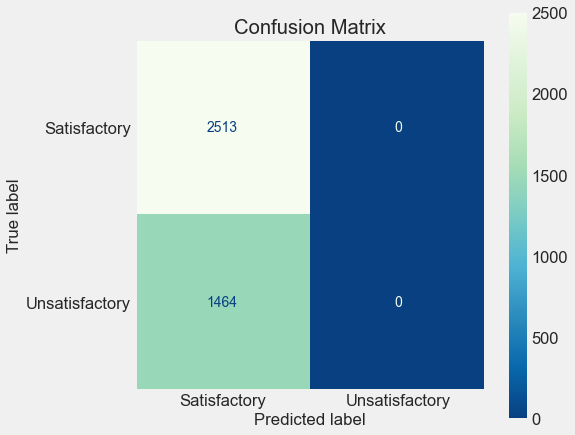

,Accuracy,F1,Recall,Precision
0,0.631883,0.0,0.0,0.0


time: 370 ms


In [24]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [25]:
mnb = MultinomialNB()

time: 720 µs


In [26]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 1.1 ms


### Fitting Model

In [27]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>)])),
                ('multinomialnb', MultinomialNB())])

time: 49.2 ms


### Saving Model

In [28]:
# f.pickle_model(fsm, 'fsm')

time: 639 µs


### Cross Val Scores

In [29]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6414082145850796
 fsm has an average F1 of 0.2976193207026414
 fsm has an average Recall of 0.20683371298405467
 fsm has an average Precision of 0.5325313609158251


[0.6414082145850796,
 0.2976193207026414,
 0.20683371298405467,
 0.5325313609158251]

time: 297 ms


### Test Data Confusion Matrix

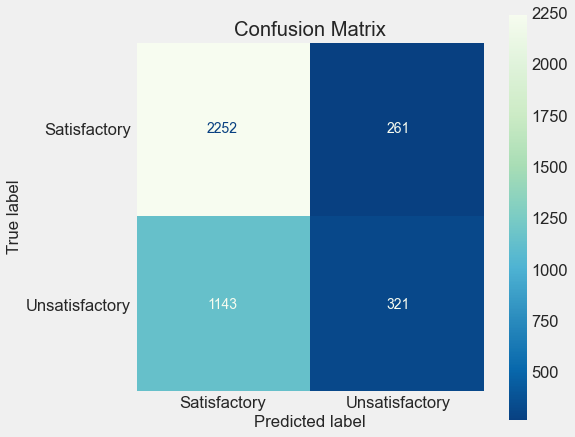

,Accuracy,F1,Recall,Precision
0,0.64697,0.313783,0.219262,0.551546


time: 345 ms


In [30]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

# Standard Scaling

## KNeighborsClassifier

In [31]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 1.15 ms


In [32]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 986 µs


### Fitting Model

In [33]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 67.5 ms


In [34]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 821 µs


### Cross Val Scores

In [35]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.6731768650461023
knn_ss has an average F1 of 0.5066946140662735
knn_ss has an average Recall of 0.45626423690205015
knn_ss has an average Precision of 0.5699639451389192


[0.6731768650461023,
 0.5066946140662735,
 0.45626423690205015,
 0.5699639451389192]

time: 6.28 s


### Test Data Confusion Matrix

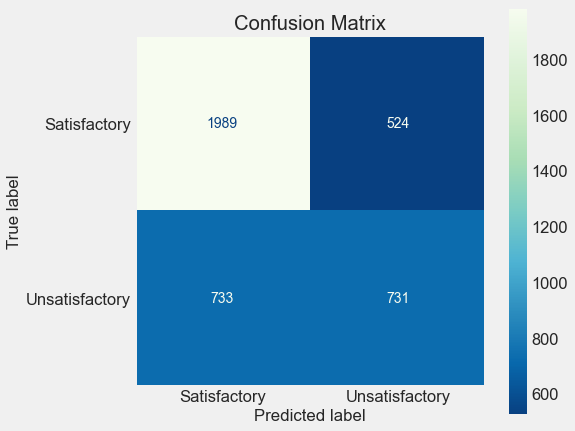

,Accuracy,F1,Recall,Precision
0,0.683933,0.537698,0.499317,0.58247


time: 11.7 s


In [36]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [37]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 1.01 ms


In [38]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.1 ms


### Fitting Model

In [39]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 3.33 s


In [40]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 808 µs


### Cross Val Scores

In [41]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7013411567476949
logreg_ss has an average F1 of 0.5109029246589216
logreg_ss has an average Recall of 0.4239179954441913
logreg_ss has an average Precision of 0.6428651660090802


[0.7013411567476949,
 0.5109029246589216,
 0.4239179954441913,
 0.6428651660090802]

time: 4.7 s


### Test Data Confusion Matrix

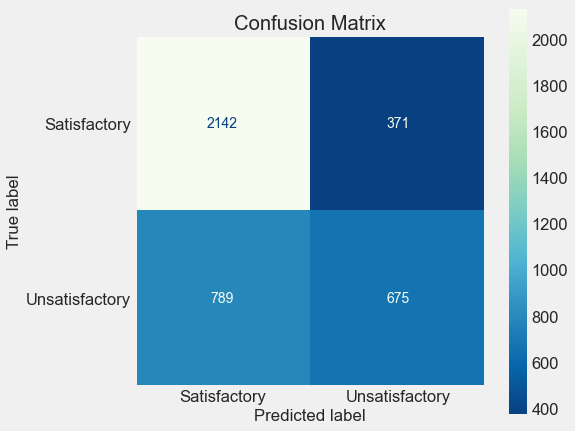

,Accuracy,F1,Recall,Precision
0,0.708323,0.537849,0.461066,0.645315


time: 308 ms


In [42]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [43]:
SVC = SVC()

time: 1.15 ms


In [44]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 1.25 ms


### Fitting Model

In [45]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('svc', SVC())])

time: 9.1 s


In [46]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 855 µs


### Cross Val Scores

In [47]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7173512154233025
svc_ss has an average F1 of 0.5328260937685945
svc_ss has an average Recall of 0.4384965831435079
svc_ss has an average Precision of 0.6795728735526628


[0.7173512154233025,
 0.5328260937685945,
 0.4384965831435079,
 0.6795728735526628]

time: 29.6 s


### Test Data Confusion Matrix

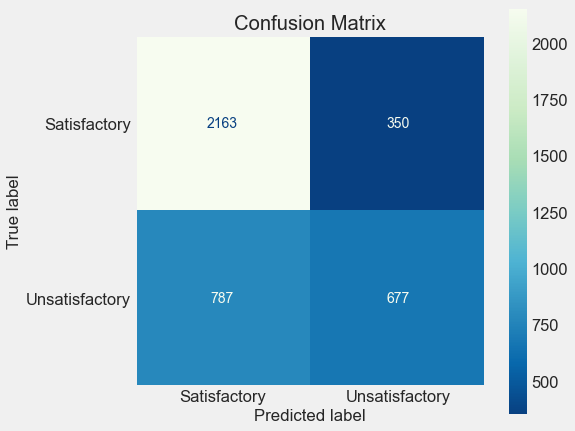

,Accuracy,F1,Recall,Precision
0,0.714106,0.543557,0.462432,0.659202


time: 9.04 s


In [48]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [49]:
LSVC = LinearSVC(random_state=2021)

time: 1.03 ms


In [50]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 1.05 ms


### Fitting Model

In [51]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 807 ms


In [52]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 689 µs


### Cross Val Scores

In [53]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7009220452640402
lsvc_ss has an average F1 of 0.5026936007795545
lsvc_ss has an average Recall of 0.4107061503416857
lsvc_ss has an average Precision of 0.6480290068685985


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.7009220452640402,
 0.5026936007795545,
 0.4107061503416857,
 0.6480290068685985]

time: 3.36 s


### Test Data Confusion Matrix

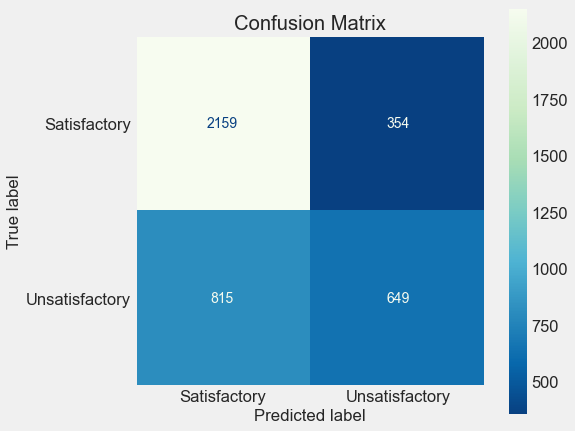

,Accuracy,F1,Recall,Precision
0,0.70606,0.526145,0.443306,0.647059


time: 236 ms


In [54]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [55]:
DT = DecisionTreeClassifier(random_state=2021)

time: 892 µs


In [56]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 1.1 ms


### Fitting Model

In [57]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 536 ms


In [58]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 924 µs


### Cross Val Scores

In [59]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6441743503772003
dt_ss has an average F1 of 0.521228086182372
dt_ss has an average Recall of 0.5264236902050115
dt_ss has an average Precision of 0.5163233243452225


[0.6441743503772003, 0.521228086182372, 0.5264236902050115, 0.5163233243452225]

time: 2.33 s


### Test Data Confusion Matrix

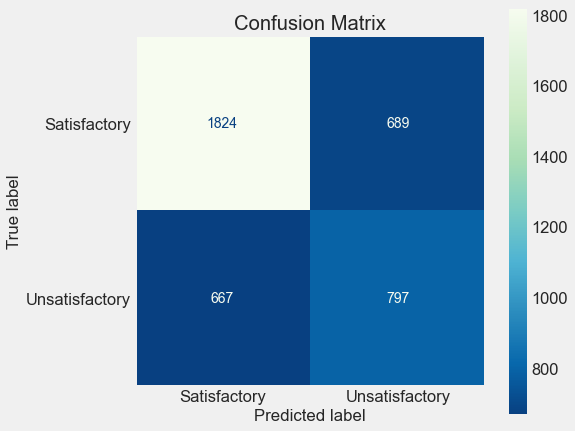

,Accuracy,F1,Recall,Precision
0,0.659039,0.540339,0.544399,0.536339


time: 235 ms


In [60]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [61]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 974 µs


In [62]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 858 µs


### Fitting Model

In [63]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 4.94 s


In [64]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 706 µs


### Cross Val Scores

In [65]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7101424979044426
bclf_ss has an average F1 of 0.5454601327355418
bclf_ss has an average Recall of 0.47266514806378135
bclf_ss has an average Precision of 0.645002711495923


[0.7101424979044426,
 0.5454601327355418,
 0.47266514806378135,
 0.645002711495923]

time: 15 s


### Test Data Confusion Matrix

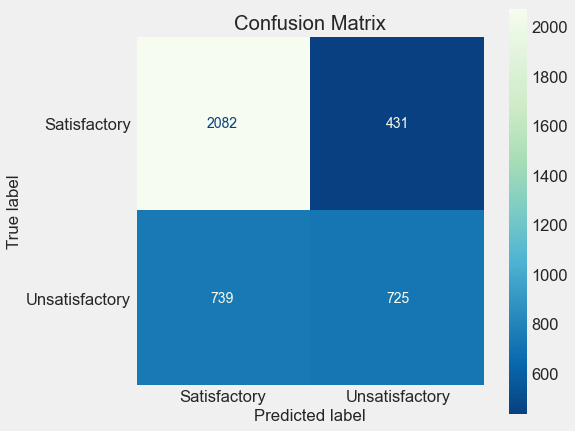

,Accuracy,F1,Recall,Precision
0,0.705808,0.553435,0.495219,0.627163


time: 310 ms


In [66]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [67]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 1.02 ms


In [68]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 957 µs


### Fitting Model

In [69]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 3.67 s


In [70]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 848 µs


### Cross Val Scores

In [71]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7230511316010059
rf_ss has an average F1 of 0.5699982401407651
rf_ss has an average Recall of 0.49931662870159454
rf_ss has an average Precision of 0.6647400583399014


[0.7230511316010059,
 0.5699982401407651,
 0.49931662870159454,
 0.6647400583399014]

time: 16.4 s


### Test Data Confusion Matrix

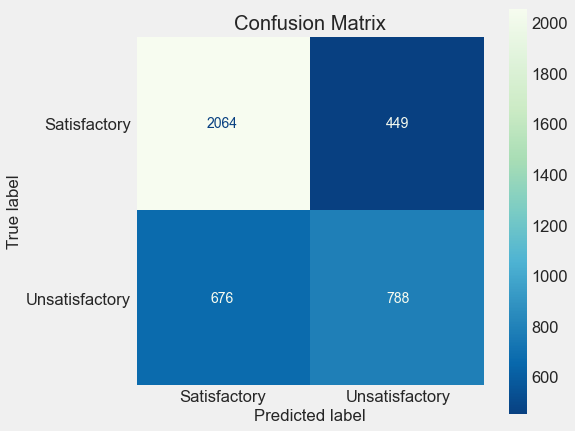

,Accuracy,F1,Recall,Precision
0,0.717123,0.583488,0.538251,0.637025


time: 607 ms


In [72]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [73]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 1.08 ms


In [74]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 1.02 ms


### Fitting Model

In [75]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 589 ms


In [76]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 950 µs


### Cross Val Scores

In [77]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6441743503772004
ada_ss has an average F1 of 0.521019499951086
ada_ss has an average Recall of 0.5259681093394077
ada_ss has an average Precision of 0.5162341478252631


[0.6441743503772004, 0.521019499951086, 0.5259681093394077, 0.5162341478252631]

time: 2.36 s


### Test Data Confusion Matrix

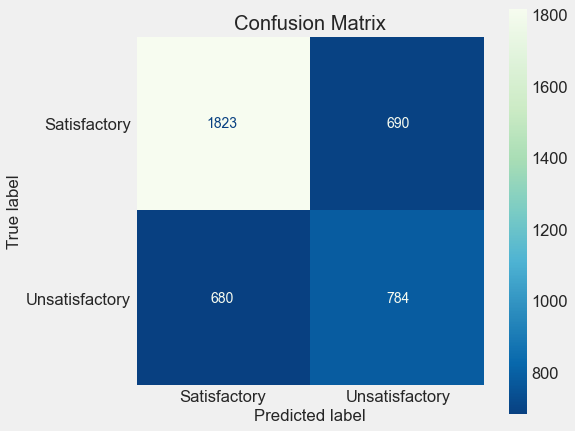

,Accuracy,F1,Recall,Precision
0,0.655519,0.533696,0.535519,0.531886


time: 333 ms


In [78]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [79]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 1.08 ms


In [80]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 1.08 ms


### Fitting Model

In [81]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.05 s


In [82]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 756 µs


### Cross Val Scores

In [83]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.7211232187761946,
 0.5823914408594472,
 0.5289293849658315,
 0.6481964202247752]

time: 4.2 s


### Test Data Confusion Matrix

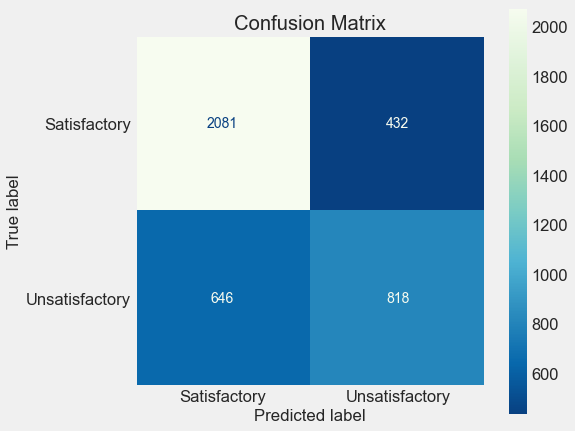

,Accuracy,F1,Recall,Precision
0,0.728941,0.6028,0.558743,0.6544


time: 414 ms


In [84]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [85]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.632020,0.000000,0.000000,0.000000,0.223477,Baseline DummyCFL
1,fsm,0.641408,0.297619,0.206834,0.532531,0.292784,FSM Naive Bayes
2,lsvc_ss,0.700922,0.502694,0.410706,0.648029,3.351055,Linear SVC SS()
3,logreg_ss,0.701341,0.510903,0.423918,0.642865,4.691973,LogReg SS()
4,svc_ss,0.717351,0.532826,0.438497,0.679573,29.608520,Support Vector CLF SS()
5,knn_ss,0.673177,0.506695,0.456264,0.569964,6.262261,KNN SS()
6,bclf_ss,0.710142,0.545460,0.472665,0.645003,14.972391,Bagging CLF SS()
7,rf_ss,0.723051,0.569998,0.499317,0.664740,16.403246,Random Forest SS()
8,ada_ss,0.644174,0.521019,0.525968,0.516234,2.358844,AdaBoost SS()
9,dt_ss,0.644174,0.521228,0.526424,0.516323,2.321782,Decision Tree CLF SS()


time: 10.2 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [86]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.23 ms


In [87]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 945 µs


### Fitting Model

In [88]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 7.08 s


In [89]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 682 µs


### Cross Val Scores

In [90]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.7289186923721711,
 0.5763368207354777,
 0.5013667425968109,
 0.6778926310988824]

time: 38.2 s


### Test Data Confusion Matrix

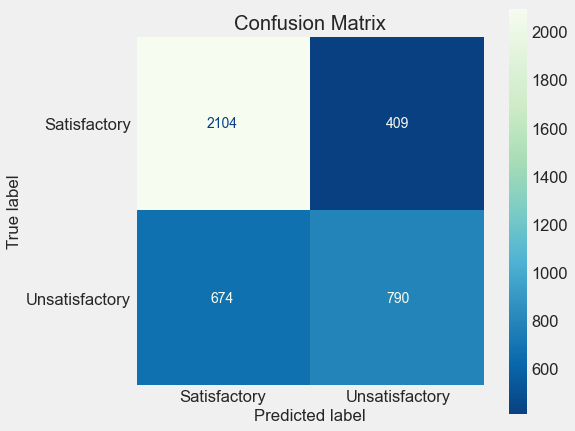

,Accuracy,F1,Recall,Precision
0,0.727684,0.593316,0.539617,0.658882


time: 1.37 s


In [91]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [92]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.632020,0.000000,0.000000,0.000000,0.223477,Baseline DummyCFL
1,fsm,0.641408,0.297619,0.206834,0.532531,0.292784,FSM Naive Bayes
2,lsvc_ss,0.700922,0.502694,0.410706,0.648029,3.351055,Linear SVC SS()
3,logreg_ss,0.701341,0.510903,0.423918,0.642865,4.691973,LogReg SS()
4,svc_ss,0.717351,0.532826,0.438497,0.679573,29.608520,Support Vector CLF SS()
5,knn_ss,0.673177,0.506695,0.456264,0.569964,6.262261,KNN SS()
6,bclf_ss,0.710142,0.545460,0.472665,0.645003,14.972391,Bagging CLF SS()
7,rf_ss,0.723051,0.569998,0.499317,0.664740,16.403246,Random Forest SS()
11,vc_ss,0.728919,0.576337,0.501367,0.677893,38.149009,Voting CLF SS()
8,ada_ss,0.644174,0.521019,0.525968,0.516234,2.358844,AdaBoost SS()


time: 14.5 ms


## SMOTE

## XGBoost SMOTE

In [93]:
xgb_sm = make_sm_pipeline(preprocessing_ss, sm, XGB)

time: 1.32 ms


### Fitting Model

In [94]:
%%capture --no-display
xgb_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('smote', SMOTE(random_state=2...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
       

time: 3.6 s


In [95]:
# f.pickle_model(xgb_sm, 'xgb_sm')

time: 1.02 ms


### Cross Val Scores

In [96]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_sm, X_train, y_train, 'xgb_sm',\
                'XGBoost SS()/SMOTE')

[0.7281642917015926, 0.602053583453702, 0.5587699316628701, 0.6527385666744391]

time: 12.7 s


### Test Data Confusion Matrix

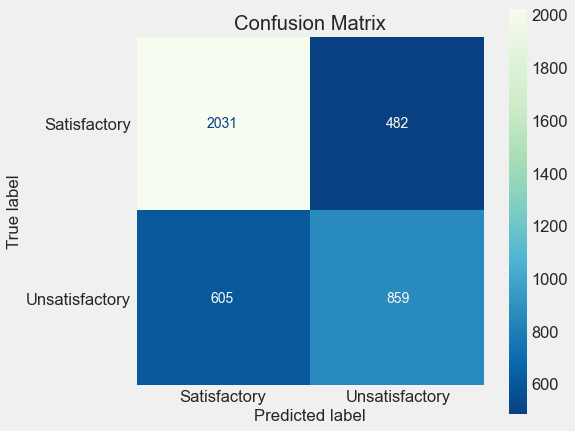

,Accuracy,F1,Recall,Precision
0,0.726678,0.612478,0.586749,0.640567


time: 490 ms


In [97]:
%%capture --no-display
f.confusion_report(xgb_sm, X_test, y_test)

## Voting CLF SMOTE

In [98]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 2.18 ms


In [99]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.13 ms


### Fitting Model

In [100]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 13 s


In [101]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 930 µs


### Cross Val Scores

In [102]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE')

[0.7245599329421626,
 0.5987451099825117,
 0.5585421412300683,
 0.6453668862438173]

time: 44.6 s


### Test Data Confusion Matrix

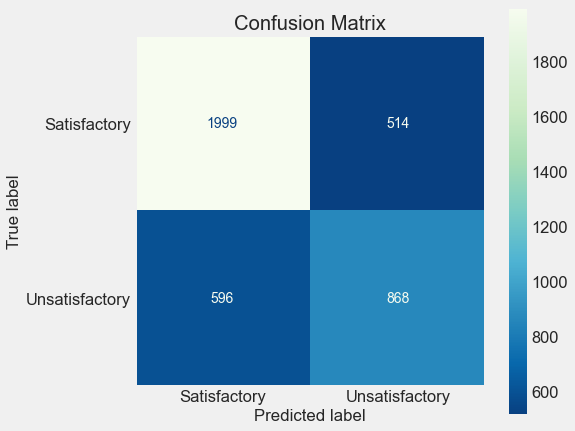

,Accuracy,F1,Recall,Precision
0,0.720895,0.609979,0.592896,0.628075


time: 1.21 s


In [103]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [105]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.632020,0.000000,0.000000,0.000000,0.223477,Baseline DummyCFL
1,fsm,0.641408,0.297619,0.206834,0.532531,0.292784,FSM Naive Bayes
2,lsvc_ss,0.700922,0.502694,0.410706,0.648029,3.351055,Linear SVC SS()
3,logreg_ss,0.701341,0.510903,0.423918,0.642865,4.691973,LogReg SS()
4,svc_ss,0.717351,0.532826,0.438497,0.679573,29.608520,Support Vector CLF SS()
5,knn_ss,0.673177,0.506695,0.456264,0.569964,6.262261,KNN SS()
6,bclf_ss,0.710142,0.545460,0.472665,0.645003,14.972391,Bagging CLF SS()
7,rf_ss,0.723051,0.569998,0.499317,0.664740,16.403246,Random Forest SS()
8,vc_ss,0.728919,0.576337,0.501367,0.677893,38.149009,Voting CLF SS()
9,ada_ss,0.644174,0.521019,0.525968,0.516234,2.358844,AdaBoost SS()


time: 14.1 ms


## Feature Importances

## XGBoost

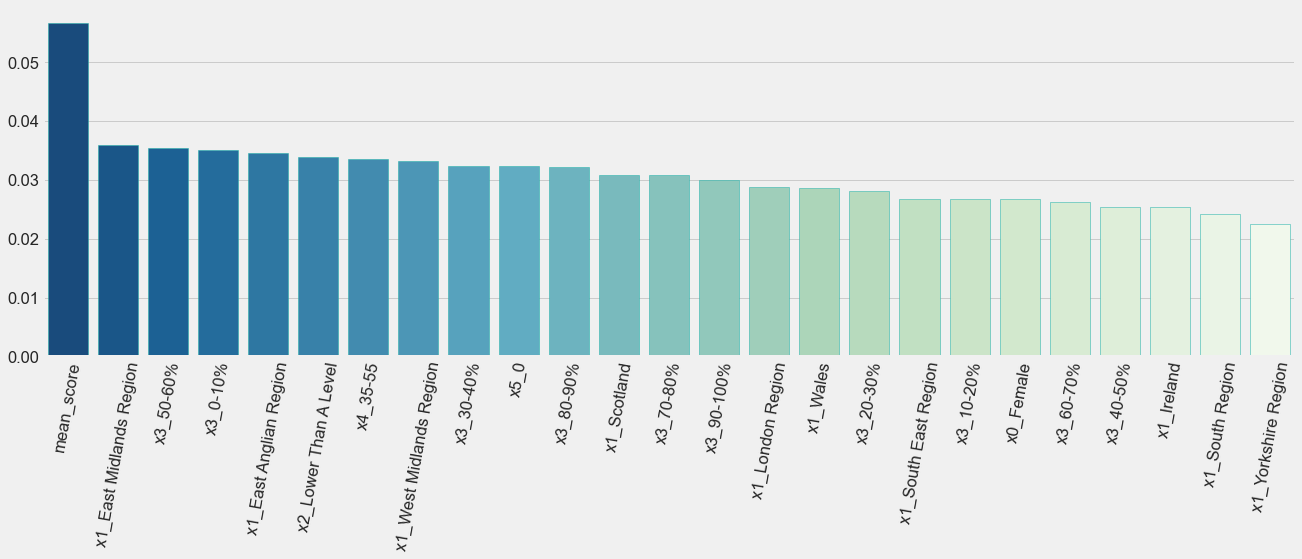

time: 671 ms


In [106]:
v.importance_plot_sm(xgb_sm, X_train)

In [107]:
# feature legend
keys = range(12)
f.get_features(keys, X_train)

0 gender
1 region
2 highest_education
3 imd_band
4 age_band
5 num_of_prev_attempts
6 disability
7 weighted_ave
8 mean_score
9 median_score
10 sum_activity
11 course_load
time: 2.38 ms


## Bagging Classifier

In [108]:
bclf_sm = make_sm_pipeline(preprocessing_ss, BCLF)
bclf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 4.95 s


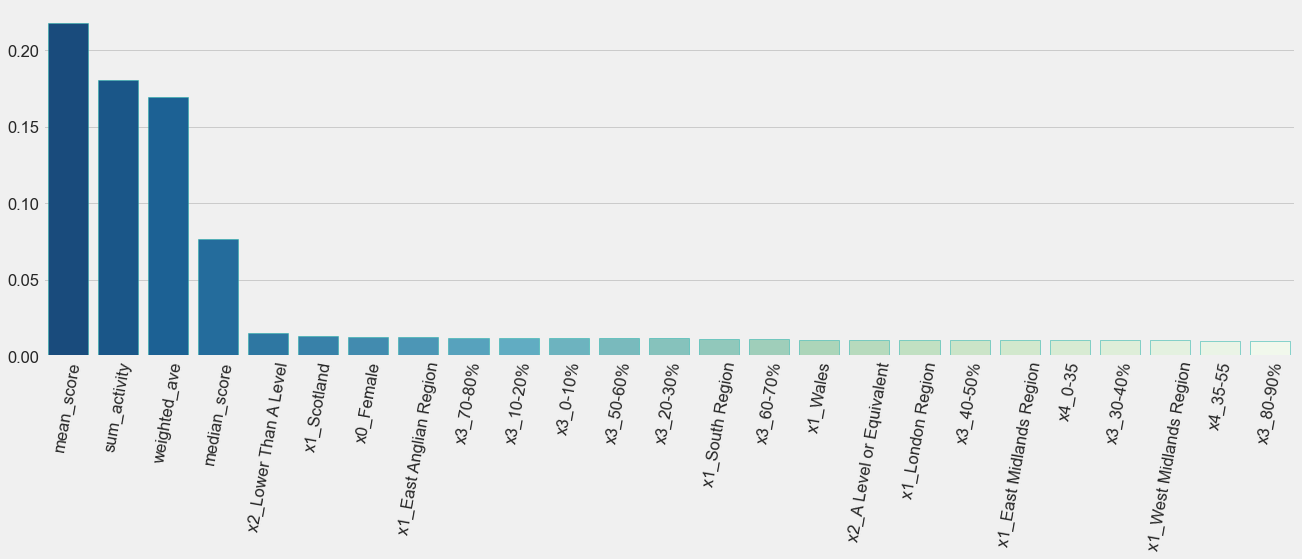

time: 449 ms


In [109]:
v.importance_plot_bclf(bclf_sm, X_train)

## Random Forest Classifier

In [110]:
rf_sm = make_sm_pipeline(preprocessing_ss, RF)
rf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x157d9a940>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e8645b0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 3.83 s


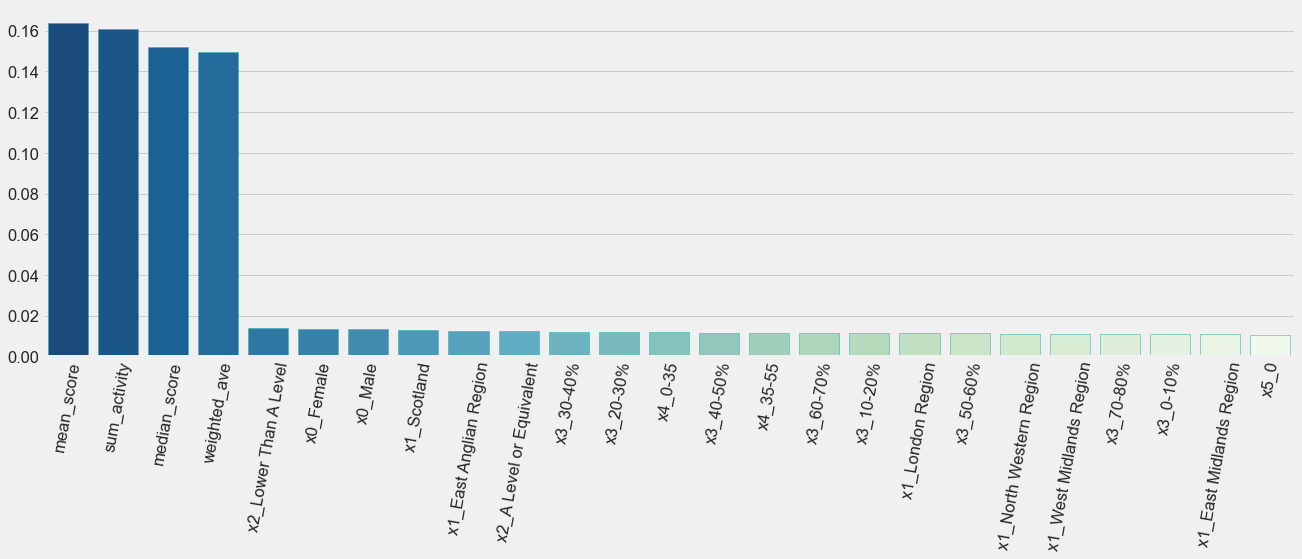

time: 517 ms


In [111]:
v.importance_plot(rf_sm, X_train)

## Permutation Importances

## Accuracy

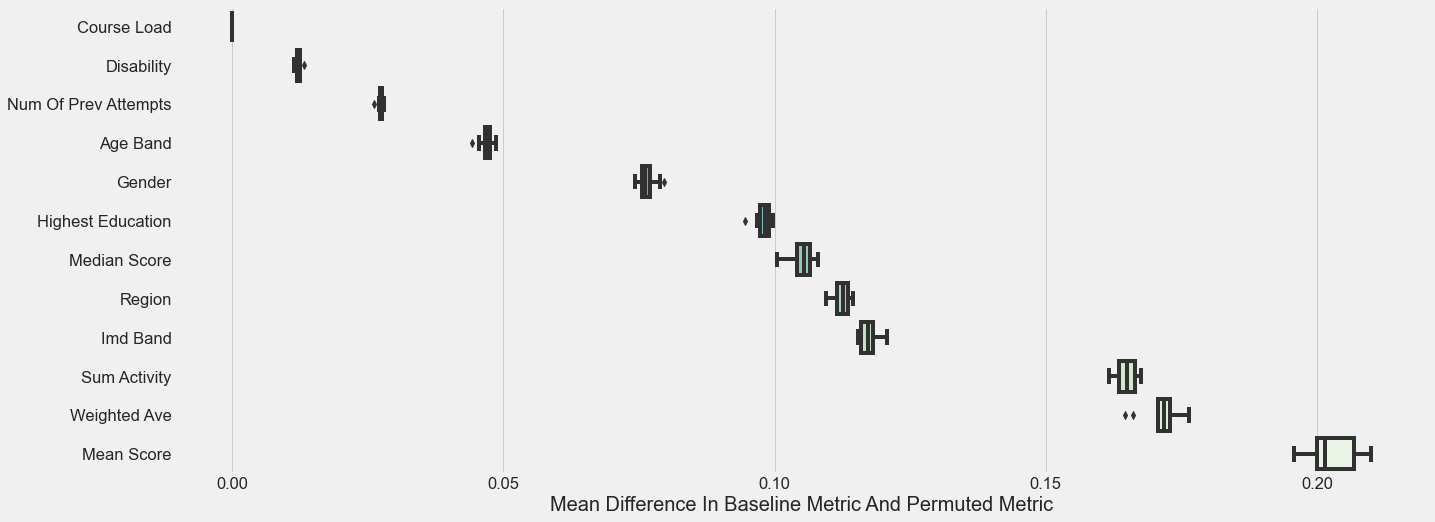

time: 29.6 s


In [112]:
f.perm_importances(vc_ss, X_train, y_train, 'accuracy')

## F1

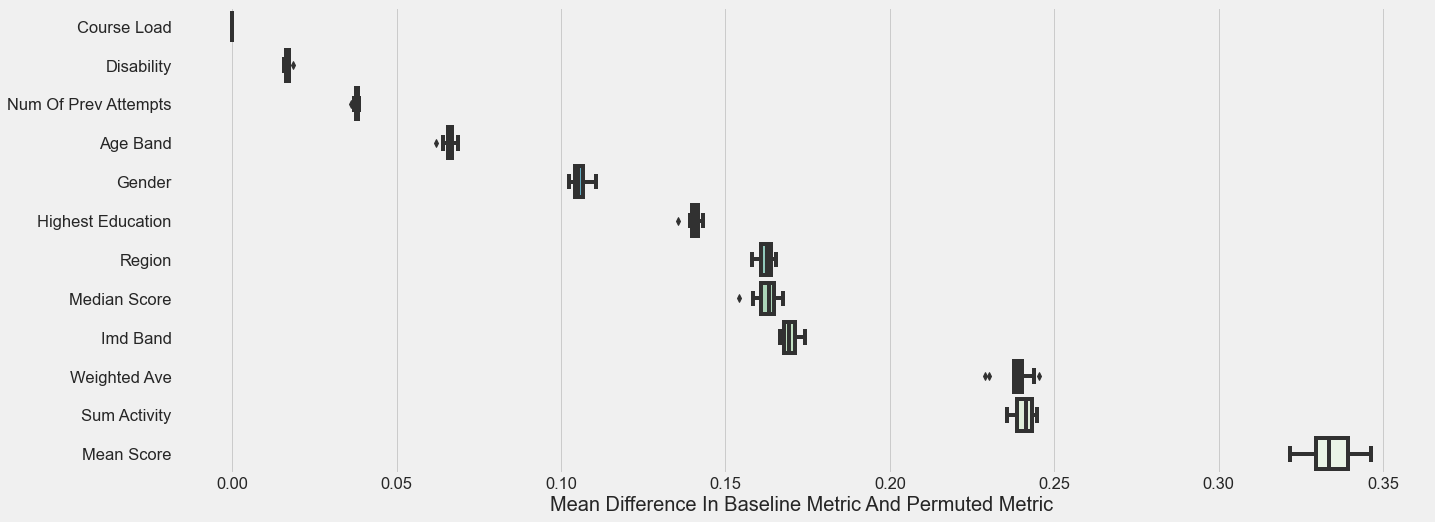

time: 34.2 s


In [113]:
f.perm_importances(vc_ss, X_train, y_train, 'f1')

## Recall

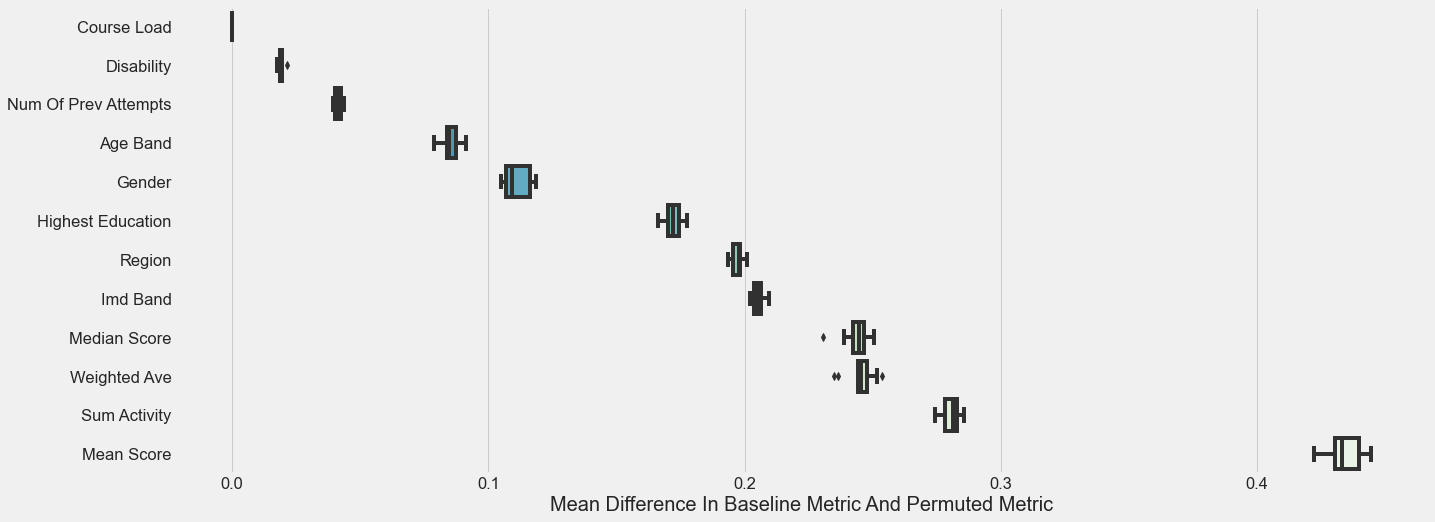

time: 31.8 s


In [114]:
f.perm_importances(vc_ss, X_train, y_train, 'recall')

## Precision

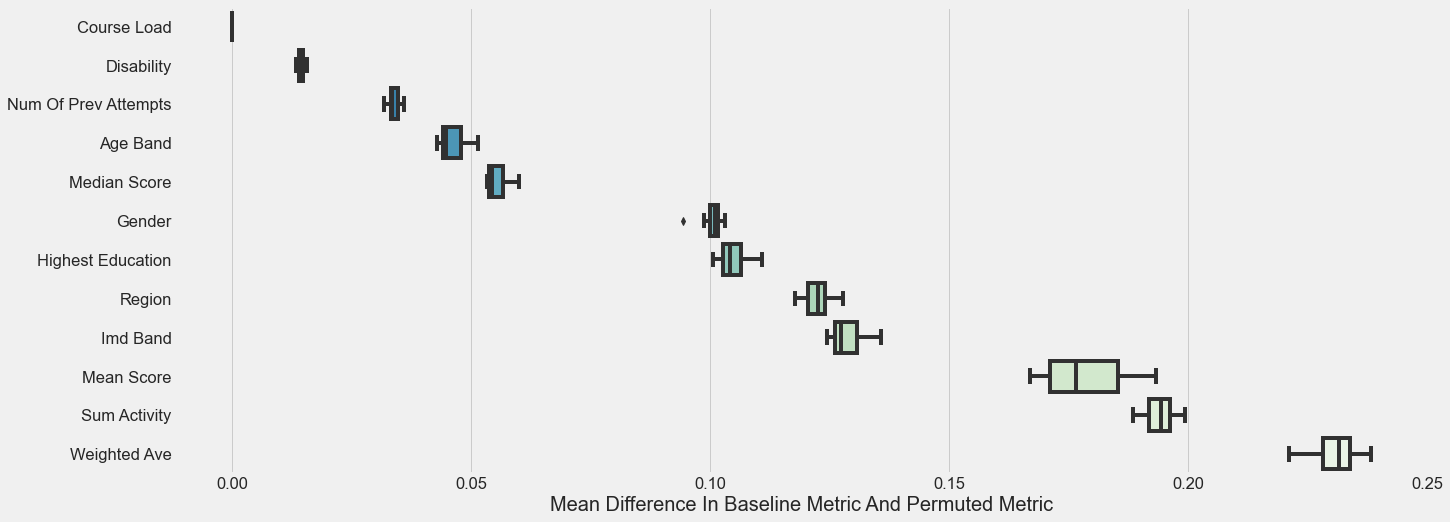

time: 28 s


In [115]:
f.perm_importances(vc_ss, X_train, y_train, 'precision')

In [116]:
%%capture --no-display
Audio(sound_file, autoplay=True)

time: 38.9 ms
